<a href="https://colab.research.google.com/github/screid/Estadistica_Computacional_UGM/blob/main/Clase_10_Analisis_multivariado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np

# 1. Análisis PCA

In [40]:
# Cargo el dataset y separo X e Y
iris = load_iris()
X = iris.data
y = iris.target

In [41]:
# Elegir y ajustar el escalador(z-score)
scaler = StandardScaler()      # media 0, varianza 1
X_scaled = scaler.fit_transform(X)

In [42]:
# Realizo descomposición PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

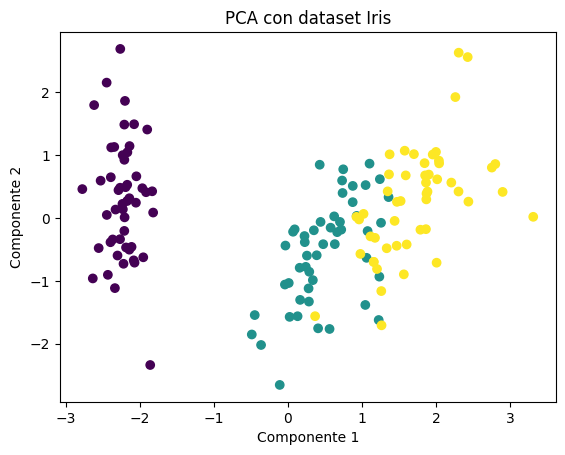

In [43]:
# Grafico
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA con dataset Iris')
plt.show()

# 2. Algoritmo K-means

Para el algoritmo K-means, se aconseja partir con el "análisis del codo", el cual nos permitirá ver el número óptimo de clusters.

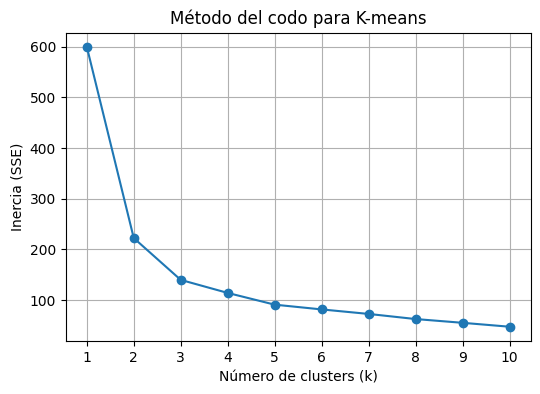

In [44]:
# ------------------------------------------------------------------
# 2. Calcular la inercia (SSE) para varios valores de k
# ------------------------------------------------------------------
k_vals   = range(1, 11)            # k = 1 … 10
inertias = []

for k in k_vals:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)   # suma de distancias cuadradas dentro del cluster

# ------------------------------------------------------------------
# 3. Gráfico del codo
# ------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(k_vals, inertias, marker='o')
plt.xticks(k_vals)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del codo para K-means')
plt.grid(True)
plt.show()

En este caso, podemos ver que el punto de más inflexión es cuando el número de clusters es 3. Por lo tanto, utilizaremos este para el análisis.

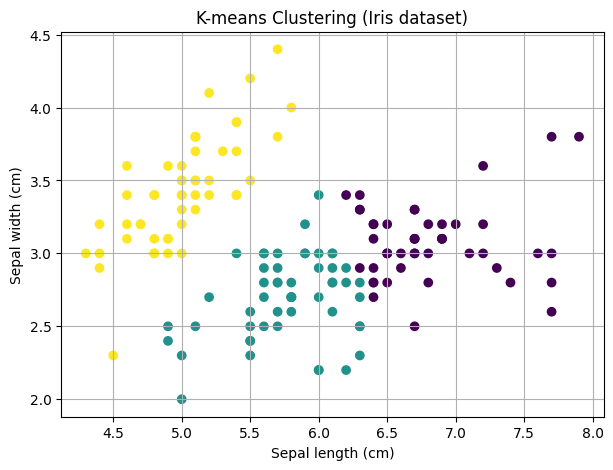

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cargar dataset Iris
X = iris.data[:, :2]  # Usamos solo las dos primeras variables para poder graficar

# Aplicar K-means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# Graficar los clusters
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering (Iris dataset)')
plt.xlabel('Sepal length (cm)')
plt.ylabel('Sepal width (cm)')
plt.grid(True)
plt.show()


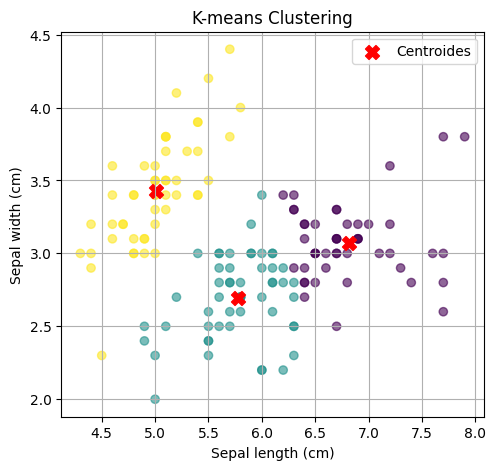

In [46]:
labels = kmeans.labels_
centroides = kmeans.cluster_centers_

# ----- Gráfico 1: Clusters predichos por K-means -----
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, marker='X', label='Centroides')
plt.title('K-means Clustering')
plt.xlabel('Sepal length (cm)')
plt.ylabel('Sepal width (cm)')
plt.legend()
plt.grid(True)

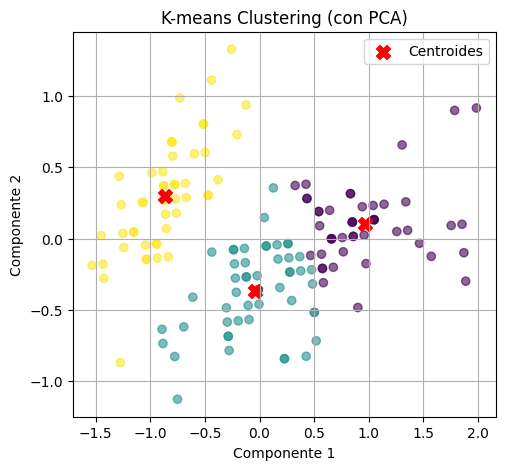

In [47]:
# Reducir a 2D con PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centroides_pca = pca.transform(kmeans.cluster_centers_)

# ----- Gráfico 1: Clusters predichos por K-means -----
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], c='red', s=100, marker='X', label='Centroides')
plt.title('K-means Clustering (con PCA)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.grid(True)

# 3. Algoritmo DBScan

Para DBSCAN no existe un “codo” sobre la inercia (SSE) porque el algoritmo no minimiza varianza interna, sino que agrupa puntos que están lo bastante cerca unos de otros. La práctica equivalente es la gráfica de k-distancia:

|. Fija min_samples (k). Valor típico: 4 - 5; si el conjunto es pequeño, usa 3.

2. Calcula la distancia al k-ésimo vecino para cada punto y ordénala de menor a mayor.

3. Dibuja la curva.
- El tramo inicial sube lento (puntos en zonas densas).
 De pronto aparece un “codo” donde la pendiente se dispara:
esa distancia es un buen candidato a eps.

4. Elige eps en el codo y vuelve a ajustar DBSCAN.

5. Si todo es ruido, sube eps o baja min_samples.

6. Si todo es un único cluster, baja eps o sube min_samples.

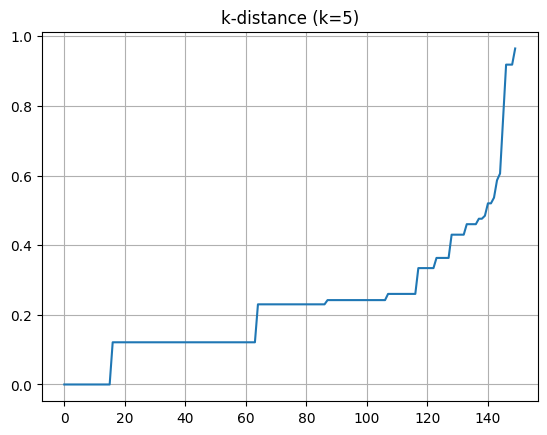

In [64]:
from sklearn.neighbors import NearestNeighbors
import numpy as np, matplotlib.pyplot as plt

k = 3                                           # igual a min_samples
nbrs  = NearestNeighbors(n_neighbors=k).fit(X_scaled)
dist, _ = nbrs.kneighbors(X_scaled)
kdist = np.sort(dist[:, k-1])                   # distancia al 5.º vecino

plt.plot(kdist); plt.title('k-distance (k=5)'); plt.grid()

En este caso, tomamos un k=3, ya que son pocos datos. Probaremos desde 0.25 hasta 0.4, ya que por ahi hay un buen número de clústers.

In [72]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# --- 1. Ajustar DBSCAN ---
X_scaled = StandardScaler().fit_transform(X)
dbscan   = DBSCAN(eps=0.35, min_samples=3)
labels   = dbscan.fit_predict(X_scaled)

In [73]:
# --- 2. Máscaras útiles ---
core_mask   = np.zeros_like(labels, dtype=bool)
core_mask[dbscan.core_sample_indices_] = True          # core points
unique_lbls = np.unique(labels)

<ipython-input-74-99959008a0b2>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_lbls))    # un color por cluster
<ipython-input-74-99959008a0b2>:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_scaled[mask & core_mask, 0],
<ipython-input-74-99959008a0b2>:20: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_scaled[mask & ~core_mask, 0],


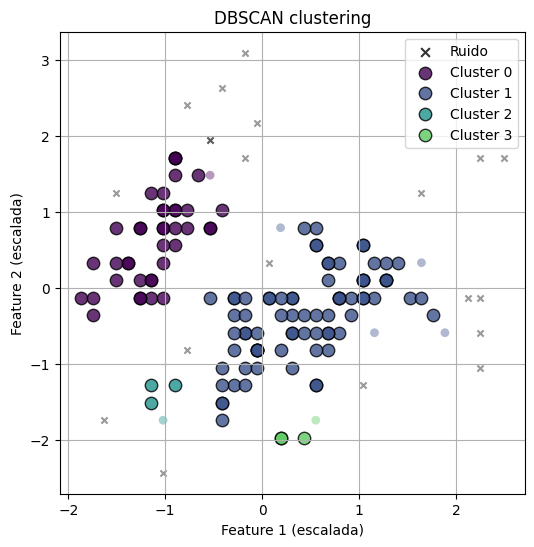

In [74]:
# --- 3. Dibujar ---
plt.figure(figsize=(6, 6))
cmap = plt.cm.get_cmap('viridis', len(unique_lbls))    # un color por cluster

for lbl in unique_lbls:
    # Color y forma
    if lbl == -1:                  # ruido
        color, marker, size, name = 'k', 'x', 40, 'Ruido'
    else:                          # cluster válido
        color = cmap(lbl)
        marker, size, name = 'o', 80, f'Cluster {lbl}'

    mask = labels == lbl
    # core points: borde más grueso
    plt.scatter(X_scaled[mask & core_mask, 0],
                X_scaled[mask & core_mask, 1],
                marker=marker, s=size, c=[color],
                edgecolors='k', label=name, alpha=0.8)
    # border points: marcador más pequeño
    plt.scatter(X_scaled[mask & ~core_mask, 0],
                X_scaled[mask & ~core_mask, 1],
                marker=marker, s=size/2, c=[color],
                edgecolors='none', alpha=0.4)

plt.title('DBSCAN clustering')
plt.xlabel('Feature 1 (escalada)')
plt.ylabel('Feature 2 (escalada)')
plt.legend()
plt.grid(True)
plt.show()